<a href="https://colab.research.google.com/github/Jay0310/Jay0310.github.io/blob/master/Amazon_fine_food_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import os
import string
import nltk
from nltk.corpus import stopwords

In [0]:
from gensim.models import word2vec
from gensim.models import KeyedVectors
from tqdm import tqdm
from bs4 import BeautifulSoup
import pickle
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_auc_score,auc
import re
from sklearn.feature_extraction.text import TfidfTransformer

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data=pd.read_csv("/content/drive/My Drive/dataset/Reviews.csv")

In [5]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
data.tail()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...
568453,568454,B001LR2CU2,A3LGQPJCZVL9UC,srfell17,0,0,5,1338422400,Great Honey,"I am very satisfied ,product is as advertised,..."


In [7]:
data.shape

(568454, 10)

In [8]:
data.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
Id                        568454 non-null int64
ProductId                 568454 non-null object
UserId                    568454 non-null object
ProfileName               568438 non-null object
HelpfulnessNumerator      568454 non-null int64
HelpfulnessDenominator    568454 non-null int64
Score                     568454 non-null int64
Time                      568454 non-null int64
Summary                   568427 non-null object
Text                      568454 non-null object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [10]:
data.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [11]:
data['Score'].value_counts()

5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

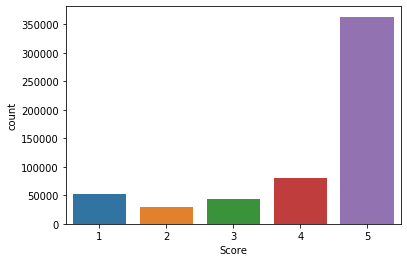

In [12]:
sns.countplot(x=data['Score'])

In [0]:
#Creating a new dataframe
temp_df = data[['UserId','HelpfulnessNumerator','HelpfulnessDenominator', 'Summary', 'Text','Score']].copy()
#Adding new feature
temp_df['Sentiments']=temp_df['Score'].apply(lambda score:'positive' if score >3 else ('negative' if score <3 else 'not defined'))

temp_df['Usefullness']=(temp_df['HelpfulnessNumerator'] / temp_df['HelpfulnessDenominator']).apply(lambda n :'>75%' if n > 0.75 else ("<25%" if n < 0.25 else ("25-75%" if n >= 0.25 and n <= 0.75 else "useless")))


In [0]:
temp_df.loc[temp_df.HelpfulnessDenominator == 0, 'Usefullness'] = ["useless"]

In [35]:
temp_df.head()

,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Summary,Text,Score,Sentiments,Usefullness
0,A3SGXH7AUHU8GW,1,1,Good Quality Dog Food,I have bought several of the Vitality canned d...,5,positive,>75%
1,A1D87F6ZCVE5NK,0,0,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,1,negative,useless
2,ABXLMWJIXXAIN,1,1,"""Delight"" says it all",This is a confection that has been around a fe...,4,positive,>75%
3,A395BORC6FGVXV,3,3,Cough Medicine,If you are looking for the secret ingredient i...,2,negative,>75%
4,A1UQRSCLF8GW1T,0,0,Great taffy,Great taffy at a great price. There was a wid...,5,positive,useless


In [36]:
temp_df.describe()

,HelpfulnessNumerator,HelpfulnessDenominator,Score
count,568454.000000,568454.00000,568454.000000
mean,1.743817,2.22881,4.183199
std,7.636513,8.28974,1.310436
min,0.000000,0.00000,1.000000
25%,0.000000,0.00000,4.000000
50%,0.000000,1.00000,5.000000
75%,2.000000,2.00000,5.000000
max,866.000000,923.00000,5.000000


In [37]:
temp_df[temp_df["Score"]==5].head()

,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Summary,Text,Score,Sentiments,Usefullness
0,A3SGXH7AUHU8GW,1,1,Good Quality Dog Food,I have bought several of the Vitality canned d...,5,positive,>75%
4,A1UQRSCLF8GW1T,0,0,Great taffy,Great taffy at a great price. There was a wid...,5,positive,useless
6,A1SP2KVKFXXRU1,0,0,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...,5,positive,useless
7,A3JRGQVEQN31IQ,0,0,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...,5,positive,useless
8,A1MZYO9TZK0BBI,1,1,Yay Barley,Right now I'm mostly just sprouting this so my...,5,positive,>75%


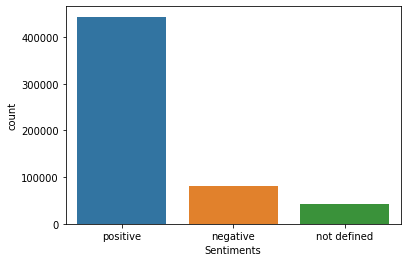

In [38]:
sns.countplot(x=temp_df['Sentiments'])

In [39]:
temp_df['Sentiments'].value_counts()

positive       443777
negative        82037
not defined     42640
Name: Sentiments, dtype: int64

In [0]:
pos = temp_df.loc[temp_df['Sentiments'] == 'positive']
pos = pos[0:25000]

neg = temp_df.loc[temp_df['Sentiments'] == 'negative']
neg = neg[0:25000]

In [41]:
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
def create_Word_Corpus(temp_df):
    words_corpus = ''
    for val in temp_df["Summary"]:
        text = str(val).lower()
        tokens = []
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if word not in stopwords.words('english')]
        for words in tokens:
            words_corpus = words_corpus + ' ' + words
    return words_corpus
        
# Generate a word cloud image
pos_wordcloud = WordCloud(width=900, height=500).generate(create_Word_Corpus(pos))
neg_wordcloud = WordCloud(width=900, height=500).generate(create_Word_Corpus(neg))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# Plot cloud
def plot_Cloud(wordCloud):
    plt.figure( figsize=(20,10), facecolor='w')
    plt.imshow(wordCloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    plt.savefig('wordclouds.png', facecolor='w', bbox_inches='tight')

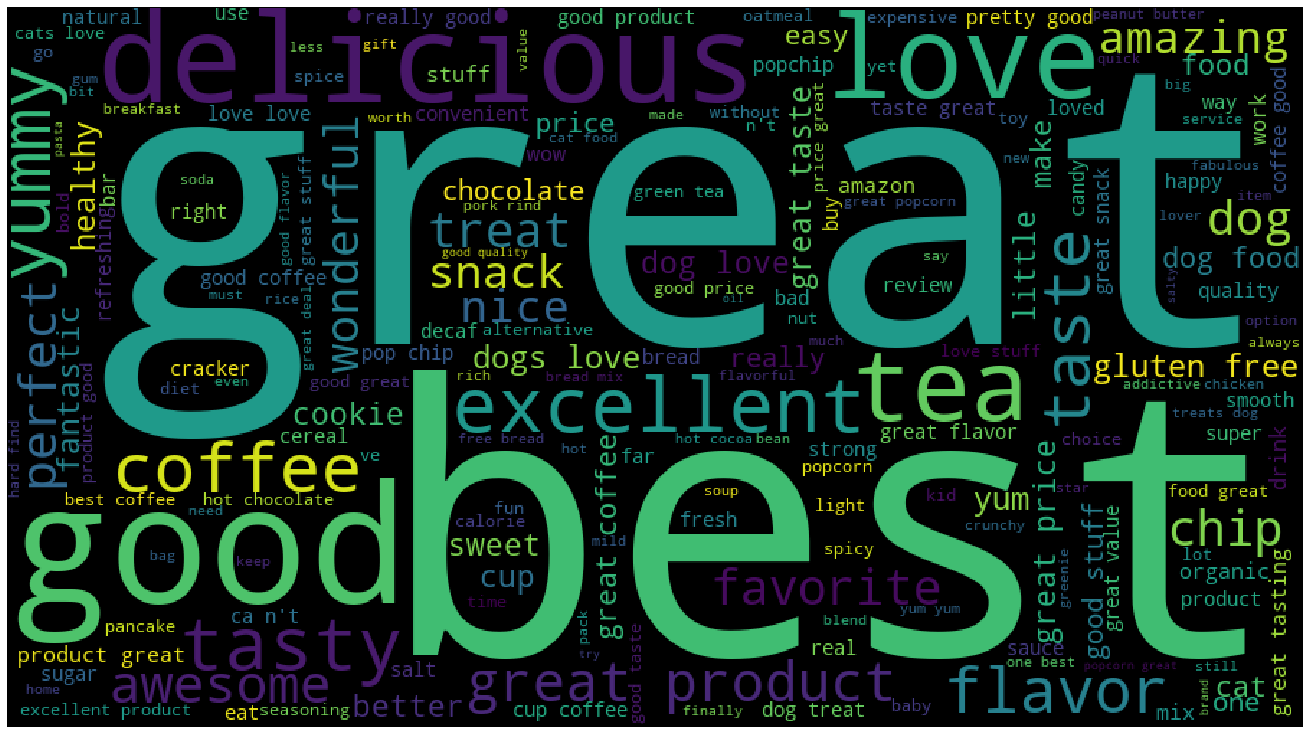

<Figure size 432x288 with 0 Axes>

In [43]:
plot_Cloud(pos_wordcloud)


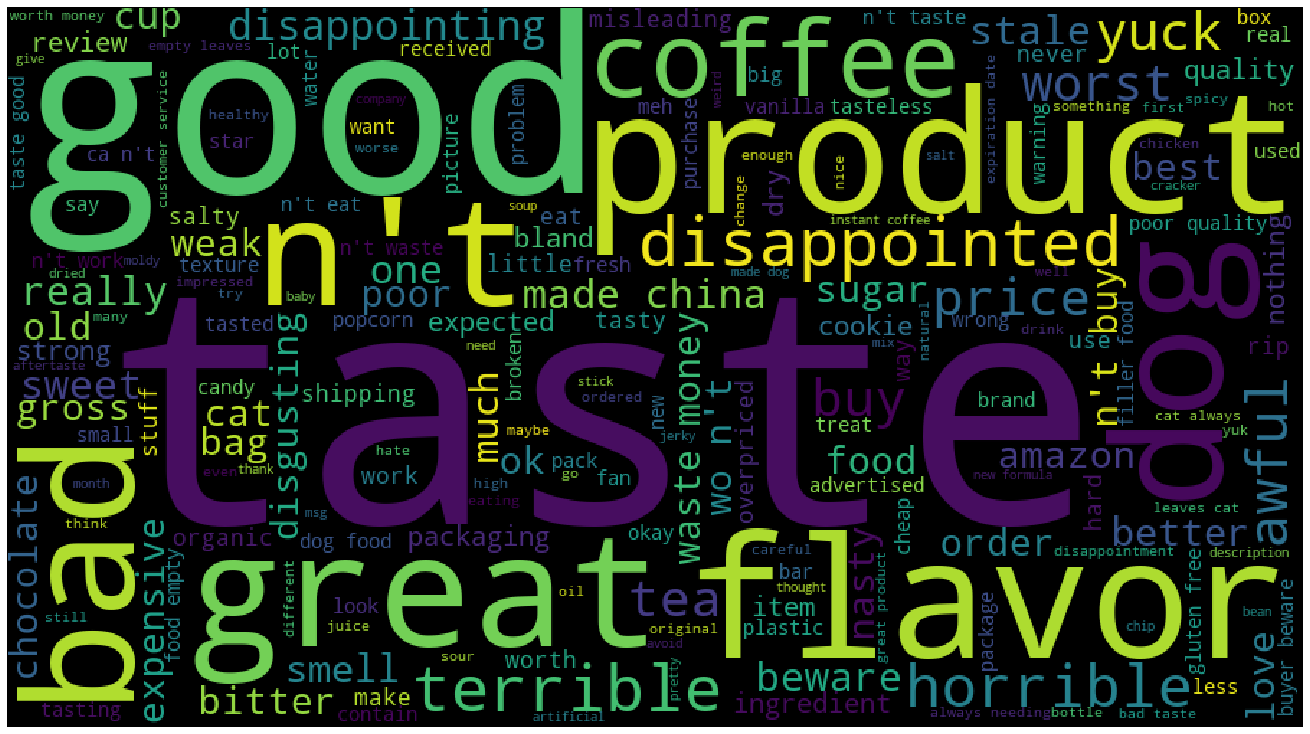

<Figure size 432x288 with 0 Axes>

In [44]:
plot_Cloud(neg_wordcloud)


In [45]:
temp_df['Usefullness'].value_counts()

useless    270052
>75%       202836
25-75%      57286
<25%        38280
Name: Usefullness, dtype: int64

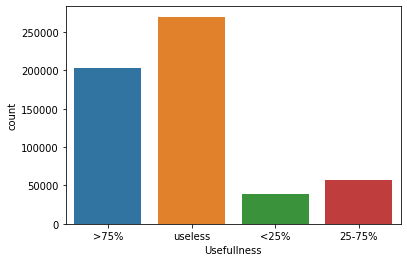

In [47]:
sns.countplot(x=temp_df['Usefullness'])

In [49]:
temp_df[temp_df.Score==5].Usefullness.value_counts()

useless    186743
>75%       142954
25-75%      21314
<25%        12111
Name: Usefullness, dtype: int64

In [50]:
temp_df[temp_df.Score==2].Usefullness.value_counts()

useless    10604
>75%        7423
25-75%      6693
<25%        5049
Name: Usefullness, dtype: int64

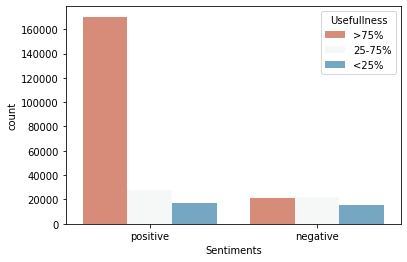

In [52]:
sns.countplot(x='Sentiments', hue='Usefullness', order=["positive", "negative"], \
              hue_order=['>75%', '25-75%', '<25%'], data=temp_df, palette='RdBu')
plt.xlabel('Sentiments')
plt.show()

In [0]:
#Word count
temp_df["text_word_count"] = temp_df["Text"].apply(lambda text: len(text.split()))


In [54]:
temp_df.head()

,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Summary,Text,Score,Sentiments,Usefullness,text_word_count
0,A3SGXH7AUHU8GW,1,1,Good Quality Dog Food,I have bought several of the Vitality canned d...,5,positive,>75%,48
1,A1D87F6ZCVE5NK,0,0,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,1,negative,useless,31
2,ABXLMWJIXXAIN,1,1,"""Delight"" says it all",This is a confection that has been around a fe...,4,positive,>75%,94
3,A395BORC6FGVXV,3,3,Cough Medicine,If you are looking for the secret ingredient i...,2,negative,>75%,41
4,A1UQRSCLF8GW1T,0,0,Great taffy,Great taffy at a great price. There was a wid...,5,positive,useless,27


In [55]:
temp_df[temp_df.Score==5].text_word_count.median()

52.0

In [56]:
temp_df[temp_df.Score==4].text_word_count.median()


65.0

In [57]:
temp_df[temp_df.Score==3].text_word_count.median()


70.0

In [58]:
temp_df[temp_df.Score==2].text_word_count.median()


67.0

In [59]:
temp_df[temp_df.Score==1].text_word_count.median()


62.0

In [0]:
x=temp_df['UserId'].value_counts()

In [62]:
x.to_dict()

{'A3OXHLG6DIBRW8': 448,
 'A1YUL9PCJR3JTY': 421,
 'AY12DBB0U420B': 389,
 'A281NPSIMI1C2R': 365,
 'A1Z54EM24Y40LL': 256,
 'A1TMAVN4CEM8U8': 204,
 'A2MUGFV2TDQ47K': 201,
 'A3TVZM3ZIXG8YW': 199,
 'A3PJZ8TU8FDQ1K': 178,
 'AQQLWCMRNDFGI': 176,
 'A2SZLNSI5KOQJT': 175,
 'A29JUMRL1US6YP': 172,
 'AZV26LP92E6WU': 167,
 'AY1EF0GOH80EK': 162,
 'A31N6KB160O508': 162,
 'A2FRFAQCWZJT3Q': 161,
 'A1UQBFCERIP7VJ': 157,
 'AKMEY1BSHSDG7': 155,
 'A1LZJZIHUPLDV4': 154,
 'A1WX42M589VAMQ': 151,
 'A3D6OI36USYOU1': 150,
 'A2Y8IDC1FKGNJC': 150,
 'A3HPCRD9RX351S': 149,
 'AKZKG2Z7CNV27': 143,
 'A2PNOU7NXB1JE4': 143,
 'A33AQPJYH7UUXR': 142,
 'A35R32TA60XD57': 141,
 'A1IU7S4HCK1XK0': 140,
 'A1X1CEGHTHMBL1': 135,
 'A36WGHR8TO5DKT': 134,
 'AQLL2R1PPR46X': 133,
 'A2DPYMNI2HCIOI': 133,
 'A3FY3H6F4249E0': 127,
 'A1HRYC60VTMYC0': 126,
 'A2GEZJHBV92EVR': 125,
 'ADS5APY1NKTL4': 125,
 'A3FKGKUCI3DG9U': 124,
 'ALSAOZ1V546VT': 123,
 'A3F3B1JPACN215': 121,
 'A1P2XYD265YE21': 120,
 'A2XNOB1T796Y6B': 119,
 'A36MP37DITBU6F': 118,
 

In [0]:
temp_df["reviewer_freq"] = temp_df["UserId"].apply(lambda counts: "Frequent (>50 reviews)" \
                                                                 if x[counts]>50 else "Not Frequent (1-50)")

In [64]:
temp_df.head()

,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Summary,Text,Score,Sentiments,Usefullness,text_word_count,reviewer_freq
0,A3SGXH7AUHU8GW,1,1,Good Quality Dog Food,I have bought several of the Vitality canned d...,5,positive,>75%,48,Not Frequent (1-50)
1,A1D87F6ZCVE5NK,0,0,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,1,negative,useless,31,Not Frequent (1-50)
2,ABXLMWJIXXAIN,1,1,"""Delight"" says it all",This is a confection that has been around a fe...,4,positive,>75%,94,Not Frequent (1-50)
3,A395BORC6FGVXV,3,3,Cough Medicine,If you are looking for the secret ingredient i...,2,negative,>75%,41,Not Frequent (1-50)
4,A1UQRSCLF8GW1T,0,0,Great taffy,Great taffy at a great price. There was a wid...,5,positive,useless,27,Not Frequent (1-50)


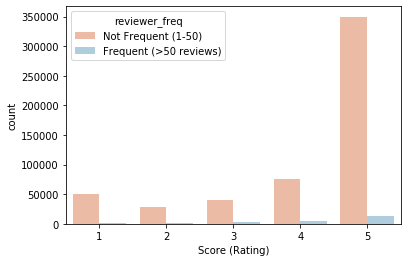

In [65]:
ax = sns.countplot(x='Score', hue='reviewer_freq', data=temp_df, palette='RdBu')
ax.set_xlabel('Score (Rating)')
plt.show()